In [ ]:
import os 
import sys
from tqdm import tqdm
import importlib
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt

module_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/"
data_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/data/long_seqs_v10/"
model_save_dir = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/discrete-seq-gan-mc'

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
tf.__version__

'2.1.0'

In [4]:
BATCH_SIZE = 256
T = 20 + 1
VOCAB = ['END/PADDING', 'INIT', 'start', 'view', 'click', 'install']
EVENT_VOCAB_DIM = len(VOCAB)
EMB_DIM = 16
HIDDEN_DIM = 16

END_TOKEN = 0

## Load Data

In [5]:
pos_data_path = os.path.join(data_path, 'positive_long_sequences.pickle')
# neg_data_path = os.path.join(data_path, 'negative_long_sequences.pickle')

def load_sequence_from_pickle_to_numpy(pickle_file_path):
    """
        A list of sequence in format of (event_type, time_delta)
    :param pickle_file_path: e.g. /.../project-basileus/seq-gan/data/fixed_length/valid_sequences.pickle
    :return: (event_type_seqs, time_delta)
    """
    with open(pickle_file_path, 'rb') as f:
        raw_seqs = pickle.load(f)

    if not raw_seqs or not raw_seqs[0]:
        return np.array([]), np.array([])

    N = len(raw_seqs)
    T = len(raw_seqs[0])
    
    seqs = np.array(raw_seqs)
#     print(seqs.shape)
    
    et_seqs = seqs[:, :, 0].astype(np.float64).reshape((N, T, 1))
    ts_seqs = seqs[:, :, 1].astype(np.float64).reshape((N, T, 1))
    return et_seqs, ts_seqs
    
pos_event_type_seqs, pos_timestamp_seqs = load_sequence_from_pickle_to_numpy(pos_data_path)
# neg_event_type_seqs, neg_timestamp_seqs = load_sequence_from_pickle_to_numpy(neg_data_path)

In [6]:
def create_dataset(features: np.array, labels: np.array, batch_size=2, epochs=10, buffer_size=10000):
    """
    Create dataset from numpy arrays
    """
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

In [7]:
BATCH_SIZE = 256
T = 20 + 1
VOCAB = ['END/PADDING', 'INIT', 'start', 'view', 'click', 'install']
EVENT_VOCAB_DIM = len(VOCAB)
EMB_DIM = 16
HIDDEN_DIM = 16

END_TOKEN = 0
MAX_TIME = 1024

## Create original SeqGan

In [10]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense, Dropout, Conv1D, Conv2D, MaxPooling1D, Activation, Multiply, Add, Lambda
from tensorflow.keras import regularizers

tf.keras.backend.set_floatx('float64')


def build_G(batch_size, event_vocab_dim, emb_dim, hidden_dim=16):
    # normal LSTM
    i_et = Input(batch_shape=(batch_size, None, 1), name='event_type')  # input of discrete feature event type
    
    embed0 = Embedding(input_dim=event_vocab_dim, output_dim=emb_dim, mask_zero=True)(i_et)
    # turn [batch_size, None, 1, emb_dim] -> [batch_size, None, emb_dim]
    embed0 = tf.squeeze(embed0, axis=2)

    hm = LSTM(hidden_dim, 
              name='lstm',
              stateful=True,
              return_sequences=False,
              kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
              recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
              bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(embed0)

    logits = Dense(event_vocab_dim,
                   activation='linear',
                   name='dense_1',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(hm)
    
    generator = Model(
        inputs=i_et,
        outputs=logits)
        
    return generator

In [11]:
# Modified from: https://gist.github.com/iskandr/a874e4cf358697037d14a17020304535
def highway_layers(value, n_layers, activation="tanh", gate_bias=-3):
    dim = K.int_shape(value)[-1]
    gate_bias_initializer = tf.keras.initializers.Constant(gate_bias)
    for i in range(n_layers):     
        gate = Dense(units=dim, bias_initializer=gate_bias_initializer, activation='sigmoid')(value)
        negated_gate = Lambda(
            lambda x: 1.0 - x,
            output_shape=(dim,))(gate)
        transformed = Dense(units=dim, activation=activation)(value)
        transformed_gated = Multiply()([gate, transformed])
        identity_gated = Multiply()([negated_gate, value])
        value = Add()([transformed_gated, identity_gated])
    return value


def build_D_CNN(T, event_vocab_dim, emb_dim, num_filters=100, kernel_size=4, dropout_rate=0.25):
    # Highway network
    i_et = Input(shape=(T, 1), name='event_type')  # input of discrete feature event type
    
    embed0 = Embedding(input_dim=event_vocab_dim, output_dim=emb_dim, mask_zero=True)(i_et)
    embed0 = tf.squeeze(embed0, axis=2)

    conv1 = Conv1D(
        filters=num_filters,
        kernel_size=kernel_size,
        strides=1,
        padding="valid",
        activation='relu',
        use_bias=True,
        kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
        bias_initializer=tf.keras.initializers.Constant(value=0.1))(embed0)
    
    pooled = MaxPooling1D(pool_size=T-kernel_size+1, strides=1)(conv1)
    
    highwayed = highway_layers(pooled, n_layers=1, activation="relu", gate_bias=0)

    dropped = Dropout(rate=dropout_rate)(highwayed)
    
    prob = Dense(1, 
                 activation='sigmoid',
                 name='final',
                 kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
                 bias_initializer=tf.keras.initializers.Constant(value=0.1))(dropped)

    discriminator = Model(
        inputs=i_et,
        outputs=prob)

    return discriminator

In [33]:
def build_D_RNN(batch_size, T, event_vocab_dim, emb_dim, dropout_rate=0.25):
    # normal LSTM
    i_et = Input(batch_shape=(batch_size, None, 1), name='event_type')  # input of discrete feature event type
    
    embed0 = Embedding(input_dim=event_vocab_dim, output_dim=emb_dim, mask_zero=True)(i_et)
    # turn [batch_size, None, 1, emb_dim] -> [batch_size, None, emb_dim]
    embed0 = tf.squeeze(embed0, axis=2)

    hm = LSTM(HIDDEN_DIM, 
              name='lstm',
              stateful=True,
              return_sequences=False,
              kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
              recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
              bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(embed0)
              
    dropped = Dropout(rate=dropout_rate)(hm)
    
    prob = Dense(1, 
             activation='sigmoid',
             name='final',
             kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
             bias_initializer=tf.keras.initializers.Constant(value=0.1))(dropped)  

    discriminator = Model(
        inputs=i_et,
        outputs=prob)

    return discriminator

## Pre-Training of original SeqGAn

In [13]:
def pretrain_discriminator(event_type_batch, label_batch, discriminator, verbose=False, optimizer=Adam(lr=0.001)):
    # train the discriminator
    with tf.GradientTape() as tape:
        # train discriminator
        true_prob = discriminator(event_type_batch)

        # cross-entropy loss
        discriminator_loss = ce_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(label_batch, true_prob, from_logits=False)
        )

        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss


def pretrain_generator(event_type_batch, generator, verbose=False, optimizer=Adam(lr=0.001)):
    _, T, _ = event_type_batch.shape

    # train the generator
    with tf.GradientTape() as tape:
        generator.reset_states()
        ce_loss_list = []

        for i in range(0, T - 1):
            curr_state_et = event_type_batch[:, i:i + 1, :]
            target_et = event_type_batch[:, i + 1, :]

            token_logits = generator(curr_state_et)

            ce_losses = tf.keras.losses.sparse_categorical_crossentropy(target_et, token_logits, from_logits=True)
            ce_loss = tf.reduce_mean(ce_losses)
            ce_loss_list.append(ce_loss)

        generator_loss = tf.reduce_mean(ce_loss_list)

    if verbose:
        print('train loss:{}'.format(generator_loss))

    # apply gradient decent per batch
    grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    return generator_loss

### pre-train G

In [42]:
N_total_G = pos_event_type_seqs.shape[0]

EPOCHS = 1
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)

pretrain_G_dataset = create_dataset(pos_event_type_seqs,
                                  np.ones((N_total_G, 1)),
                                  batch_size=BATCH_SIZE,
                                  epochs=EPOCHS,
                                  buffer_size=N_total_G)

In [43]:
pretrain_gen_ce_loss_history = []
pretrain_gen_metrics_history = []

pretrained_generator = build_G(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

In [44]:
step = 0
OPTIMIZER = Adam(lr=1e-3)
_TOTAL_STEPS = 100  # suppose we only has 100 batches

for event_type_batch, _ in tqdm(pretrain_G_dataset.take(_TOTAL_STEPS)):
    step += 1
    print('Training Step:', step)
        
    gen_ce_loss =  pretrain_generator(event_type_batch, pretrained_generator, verbose=True, optimizer=OPTIMIZER)                    
    pretrain_gen_ce_loss_history.append(gen_ce_loss.numpy())

1it [00:00,  3.00it/s]

Training Step: 1
train loss:1.8733454842391624
Training Step: 2


3it [00:00,  5.29it/s]

train loss:1.8699141962692352
Training Step: 3
train loss:1.8673622389196047
Training Step: 4


5it [00:00,  6.09it/s]

train loss:1.8654005062069299
Training Step: 5
train loss:1.8618666576882337
Training Step: 6


7it [00:01,  6.43it/s]

train loss:1.859323195229657
Training Step: 7
train loss:1.8569507398232297
Training Step: 8


9it [00:01,  6.55it/s]

train loss:1.8540238143888481
Training Step: 9
train loss:1.851669184355058
Training Step: 10


11it [00:01,  6.57it/s]

train loss:1.8490487554723054
Training Step: 11
train loss:1.845790562245773
Training Step: 12


13it [00:02,  6.61it/s]

train loss:1.843755510736853
Training Step: 13
train loss:1.8410615398214472
Training Step: 14


15it [00:02,  6.73it/s]

train loss:1.8390057294988993
Training Step: 15
train loss:1.8369176552600295
Training Step: 16


17it [00:02,  6.03it/s]

train loss:1.8341304625103063
Training Step: 17
train loss:1.8311816393466471
Training Step: 18


19it [00:03,  6.39it/s]

train loss:1.8286592991885215
Training Step: 19
train loss:1.8271684461966458
Training Step: 20


21it [00:03,  6.58it/s]

train loss:1.8248504016940068
Training Step: 21
train loss:1.8209681806163505
Training Step: 22


23it [00:03,  6.67it/s]

train loss:1.8189253701415828
Training Step: 23
train loss:1.8164316319537286
Training Step: 24


25it [00:03,  6.70it/s]

train loss:1.8132050817646117
Training Step: 25
train loss:1.80963953928157
Training Step: 26


27it [00:04,  6.73it/s]

train loss:1.8085402449950618
Training Step: 27
train loss:1.806299336299174
Training Step: 28


29it [00:04,  6.78it/s]

train loss:1.8011606327207523
Training Step: 29
train loss:1.7998807622247874
Training Step: 30


31it [00:04,  6.73it/s]

train loss:1.7958017367064283
Training Step: 31
train loss:1.7935297771191252
Training Step: 32


33it [00:05,  6.71it/s]

train loss:1.7909912162954764
Training Step: 33
train loss:1.7880775631054089
Training Step: 34


35it [00:05,  6.74it/s]

train loss:1.7836108114128684
Training Step: 35
train loss:1.780646137137446
Training Step: 36


37it [00:05,  6.74it/s]

train loss:1.7775416395352384
Training Step: 37
train loss:1.775047688925992
Training Step: 38


39it [00:06,  6.75it/s]

train loss:1.7712089239016102
Training Step: 39
train loss:1.76836758294404
Training Step: 40


41it [00:06,  6.73it/s]

train loss:1.764062444831054
Training Step: 41
train loss:1.7596661041270245
Training Step: 42


43it [00:06,  6.72it/s]

train loss:1.7565268380863643
Training Step: 43
train loss:1.7519552394681681
Training Step: 44


45it [00:06,  6.75it/s]

train loss:1.74748461459596
Training Step: 45
train loss:1.7425911123918247
Training Step: 46


47it [00:07,  6.74it/s]

train loss:1.738089438542152
Training Step: 47
train loss:1.7338586197644823
Training Step: 48


49it [00:07,  6.76it/s]

train loss:1.727413214981468
Training Step: 49
train loss:1.7233259246590265
Training Step: 50


51it [00:07,  6.72it/s]

train loss:1.716905219031196
Training Step: 51
train loss:1.7118405057195165
Training Step: 52


53it [00:08,  6.73it/s]

train loss:1.704905187695514
Training Step: 53
train loss:1.6994489527103898
Training Step: 54


55it [00:08,  6.74it/s]

train loss:1.6933732209868055
Training Step: 55
train loss:1.6852329514408333
Training Step: 56


57it [00:08,  6.74it/s]

train loss:1.6784508089918002
Training Step: 57
train loss:1.670826324087497
Training Step: 58


59it [00:09,  6.76it/s]

train loss:1.6625673197738222
Training Step: 59
train loss:1.6552996410219705
Training Step: 60


61it [00:09,  6.77it/s]

train loss:1.6483465097164718
Training Step: 61
train loss:1.6389602288431075
Training Step: 62


63it [00:09,  6.79it/s]

train loss:1.631360725450191
Training Step: 63
train loss:1.6224888934993498
Training Step: 64


65it [00:09,  6.78it/s]

train loss:1.6146008654342148
Training Step: 65
train loss:1.6034386020907143
Training Step: 66


67it [00:10,  6.74it/s]

train loss:1.5963540679439912
Training Step: 67
train loss:1.5868990559540386
Training Step: 68


69it [00:10,  6.76it/s]

train loss:1.5774361443309803
Training Step: 69
train loss:1.5716283526598627
Training Step: 70


71it [00:10,  6.12it/s]

train loss:1.5639424395586705
Training Step: 71
train loss:1.5568084016197208
Training Step: 72


73it [00:11,  6.40it/s]

train loss:1.5498402280385863
Training Step: 73
train loss:1.5423324273884838
Training Step: 74


75it [00:11,  6.56it/s]

train loss:1.5341621100508387
Training Step: 75
train loss:1.5303548233072057
Training Step: 76


77it [00:11,  6.67it/s]

train loss:1.522583281494073
Training Step: 77
train loss:1.5143416979715432
Training Step: 78


79it [00:12,  6.64it/s]

train loss:1.5144668813839157
Training Step: 79
train loss:1.5064020320157312
Training Step: 80


81it [00:12,  6.71it/s]

train loss:1.499299835444265
Training Step: 81
train loss:1.4921486619699773
Training Step: 82


83it [00:12,  6.74it/s]

train loss:1.4902137896633618
Training Step: 83
train loss:1.485008263196044
Training Step: 84


85it [00:12,  6.76it/s]

train loss:1.4818472511645853
Training Step: 85
train loss:1.4765420811997245
Training Step: 86


87it [00:13,  6.76it/s]

train loss:1.4726558687758673
Training Step: 87
train loss:1.4680242246313067
Training Step: 88


89it [00:13,  6.79it/s]

train loss:1.4628063972416048
Training Step: 89
train loss:1.4644315621869428
Training Step: 90


91it [00:13,  6.77it/s]

train loss:1.4592137761594803
Training Step: 91
train loss:1.454067443540449
Training Step: 92


93it [00:14,  6.70it/s]

train loss:1.4492870157754605
Training Step: 93
train loss:1.447622534948526
Training Step: 94


95it [00:14,  6.70it/s]

train loss:1.4454110974896301
Training Step: 95
train loss:1.446217975577531
Training Step: 96


97it [00:14,  6.76it/s]

train loss:1.4434563320808242
Training Step: 97
train loss:1.4382715625917206
Training Step: 98


99it [00:15,  6.73it/s]

train loss:1.4379346623667342
Training Step: 99
train loss:1.4340929440484005
Training Step: 100


100it [00:15,  6.56it/s]

train loss:1.431338543056747


In [45]:
if not os.path.exists(model_save_dir + '/pretrained_gen_weights'):
    os.makedirs(model_save_dir + '/pretrained_gen_weights')

G_save_path = model_save_dir + '/pretrained_gen_weights/model.tf'
pretrained_generator.save_weights(G_save_path)

In [46]:
reload_pretrained_gen = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

reload_pretrained_gen.build(input_shape=((BATCH_SIZE, T, 1)))
reload_pretrained_gen.load_weights(G_save_path)
reload_pretrained_gen.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
event_type (InputLayer)      [(256, None, 1)]          0         
_________________________________________________________________
embedding_8 (Embedding)      (256, None, 1, 16)        96        
_________________________________________________________________
tf_op_layer_Squeeze_8 (Tenso [(256, None, 16)]         0         
_________________________________________________________________
lstm (LSTM)                  (256, 16)                 2112      
_________________________________________________________________
dense_1 (Dense)              (256, 6)                  102       
Total params: 2,310
Trainable params: 2,310
Non-trainable params: 0
_________________________________________________________________


In [70]:
def rollout_from_prefix(
        G, batch_size, prefix, L=T, end_token=0, init_token=1):
    # Begin from dummy init state (init_token=1, init_timestamp=0.0)
    all_state_et = prefix
    l_prefix = prefix.shape[1]
    
    G.reset_states()

    for _ in range(L-l_prefix):  # sequence length
        curr_state_et = all_state_et[:, -1:, :]
        token_logits = G(curr_state_et)
        
        sampled_et = tf.random.categorical(token_logits, num_samples=1, dtype=tf.int32)
        sampled_et = tf.reshape(sampled_et, [batch_size, 1, 1])

        # cast sampled_et into float
        sampled_et = tf.cast(sampled_et, dtype=tf.float64)

        # Do NOT stop genererating once hit end_token
        all_state_et = tf.concat([all_state_et, sampled_et], axis=1)

    return all_state_et



def generate_sequences(N_gen, generator, batch_size, T):
    """
        Generate sequences batch per batch
    :param N_gen: total number of seqs to be generated
    :param generator:
    :param batch_size:
    :param T:
    :return: a python list of shape [N_gen, T, 1]
    """
    N = 0
    all_type_seq = None
    init_prefix = tf.ones([batch_size, 1, 1], dtype=tf.float64)
    
    while N < N_gen:
        batch_state_et = rollout_from_prefix(generator, batch_size, init_prefix, T)
        batch_type_seq = batch_state_et.numpy()

        if all_type_seq is None:
            all_type_seq = batch_type_seq
        else:
            all_type_seq = tf.concat([all_type_seq, batch_type_seq], axis=0)

        N += batch_size

    all_type_seq = all_type_seq[:N_gen, :, :]

    return all_type_seq

### pre-train D

In [48]:
N_fake_D = N_real_D = N_total_G // 2

In [49]:
# generate fake data by pre-trained G to pre-train D
fake_pos_event_type_seqs = generate_sequences(N_fake_D, pretrained_generator, BATCH_SIZE, T)

In [ ]:
# # generate fake data by random G to pre-train D
# random_G = build_G(
#     batch_size=BATCH_SIZE,
#     event_vocab_dim = EVENT_VOCAB_DIM,
#     emb_dim = EMB_DIM,
#     hidden_dim= HIDDEN_DIM)

# fake_pos_event_type_seqs = np.array(generate_sequences(N_fake_D, random_G, BATCH_SIZE, T))

In [50]:
# generate fake data by G to pre-train D
real_pos_event_type_seqs = pos_event_type_seqs[0:N_real_D, :, :]

In [54]:
N_total_D = N_fake_D + N_real_D

pretrain_D_et = tf.concat([fake_pos_event_type_seqs, real_pos_event_type_seqs], axis=0)
pretrain_D_labels = tf.concat([np.zeros((N_fake_D, 1)), np.ones((N_real_D, 1))], axis=0)

EPOCHS = 1
_TOTAL_STEPS = int(EPOCHS * N_total_D / BATCH_SIZE)

pretrain_D_dataset = create_dataset(pretrain_D_et,
                                    pretrain_D_labels,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS,
                                    buffer_size=N_total_D) # shuffle the entire Dataset

In [55]:
pretrain_disc_token_loss_history = []

pretrained_discriminator = build_D_RNN(batch_size=BATCH_SIZE,
                                   T=T,
                                   event_vocab_dim=EVENT_VOCAB_DIM,
                                   emb_dim=EMB_DIM,
                                   dropout_rate=0.25)

In [56]:
step = 0
OPTIMIZER = Adam(lr=1e-3)

for event_type_batch, labels in tqdm(pretrain_D_dataset.take(_TOTAL_STEPS)):
    step += 1
    print('Training Step:', step)

    disc_token_loss = pretrain_discriminator(event_type_batch, labels, pretrained_discriminator, verbose=True, optimizer=OPTIMIZER)
    pretrain_disc_token_loss_history.append(disc_token_loss.numpy())

1it [00:00,  4.26it/s]

Training Step: 1
total discriminator loss:0.6896384023012484
Training Step: 2
total discriminator loss:0.6932112734779359
Training Step: 3
total discriminator loss:0.6949274512997571


5it [00:00, 12.75it/s]

Training Step: 4
total discriminator loss:0.6904173455387378
Training Step: 5
total discriminator loss:0.6932450348771125
Training Step: 6
total discriminator loss:0.703140289935611
Training Step: 7
total discriminator loss:0.6991056820238568


9it [00:00, 15.53it/s]

Training Step: 8
total discriminator loss:0.6886088394855816
Training Step: 9
total discriminator loss:0.6967253727267031
Training Step: 10
total discriminator loss:0.6974661118214633
Training Step: 11
total discriminator loss:0.6929234842217724


13it [00:00, 13.74it/s]

Training Step: 12
total discriminator loss:0.6939859046092304
Training Step: 13
total discriminator loss:0.6925858165301702
Training Step: 14


17it [00:01, 15.71it/s]

total discriminator loss:0.6951576198371769
Training Step: 15
total discriminator loss:0.691610131297099
Training Step: 16
total discriminator loss:0.6944379441160982
Training Step: 17
total discriminator loss:0.6925523950188104
Training Step: 18


21it [00:01, 16.63it/s]

total discriminator loss:0.6916294059975056
Training Step: 19
total discriminator loss:0.6953628077512961
Training Step: 20
total discriminator loss:0.6941305281412558
Training Step: 21
total discriminator loss:0.6914918557341896
Training Step: 22


25it [00:01, 17.19it/s]

total discriminator loss:0.6956699124454355
Training Step: 23
total discriminator loss:0.6939908053465633
Training Step: 24
total discriminator loss:0.6915132764307659
Training Step: 25
total discriminator loss:0.6910770942099858
Training Step: 26


29it [00:01, 17.56it/s]

total discriminator loss:0.6934863357611858
Training Step: 27
total discriminator loss:0.691846256217949
Training Step: 28
total discriminator loss:0.6940950392202974
Training Step: 29
total discriminator loss:0.6937147022615662
Training Step: 30


33it [00:02, 17.75it/s]

total discriminator loss:0.6926181606342039
Training Step: 31
total discriminator loss:0.6948929452549537
Training Step: 32
total discriminator loss:0.692446700763158
Training Step: 33
total discriminator loss:0.6948031310549315
Training Step: 34


37it [00:02, 17.76it/s]

total discriminator loss:0.6930499406030505
Training Step: 35
total discriminator loss:0.69317923840769
Training Step: 36
total discriminator loss:0.6949993242457779
Training Step: 37
total discriminator loss:0.6919940378667906
Training Step: 38


41it [00:02, 17.68it/s]

total discriminator loss:0.6927676503862815
Training Step: 39
total discriminator loss:0.6929228339089132
Training Step: 40
total discriminator loss:0.6922758937552939
Training Step: 41
total discriminator loss:0.694915560657791
Training Step: 42


45it [00:02, 17.88it/s]

total discriminator loss:0.6929566684065962
Training Step: 43
total discriminator loss:0.6924566360933306
Training Step: 44
total discriminator loss:0.692491464491445
Training Step: 45
total discriminator loss:0.6940161897056505
Training Step: 46


49it [00:03, 17.87it/s]

total discriminator loss:0.6926083203720805
Training Step: 47
total discriminator loss:0.6932403803381297
Training Step: 48
total discriminator loss:0.6924944076310009
Training Step: 49
total discriminator loss:0.6922849045170416
Training Step: 50


53it [00:03, 17.89it/s]

total discriminator loss:0.6923760933377673
Training Step: 51
total discriminator loss:0.6928295765770365
Training Step: 52
total discriminator loss:0.6922285542858753
Training Step: 53
total discriminator loss:0.6927695365747952
Training Step: 54


57it [00:03, 17.87it/s]

total discriminator loss:0.6924214101960114
Training Step: 55
total discriminator loss:0.6923742876563432
Training Step: 56
total discriminator loss:0.6929183148392564
Training Step: 57
total discriminator loss:0.6924822881865231
Training Step: 58


61it [00:03, 17.75it/s]

total discriminator loss:0.6915117132530277
Training Step: 59
total discriminator loss:0.6923901231880275
Training Step: 60
total discriminator loss:0.6925555205823812
Training Step: 61
total discriminator loss:0.6926375271018423
Training Step: 62


65it [00:03, 17.71it/s]

total discriminator loss:0.6932407199715898
Training Step: 63
total discriminator loss:0.6921705490519734
Training Step: 64
total discriminator loss:0.6922925443829583
Training Step: 65
total discriminator loss:0.6920622681444308
Training Step: 66


69it [00:04, 17.65it/s]

total discriminator loss:0.6910326931336854
Training Step: 67
total discriminator loss:0.6921023437521427
Training Step: 68
total discriminator loss:0.6921354894915746
Training Step: 69
total discriminator loss:0.6919290079508711
Training Step: 70


73it [00:04, 17.57it/s]

total discriminator loss:0.6920491941131605
Training Step: 71
total discriminator loss:0.6931650492255833
Training Step: 72
total discriminator loss:0.6918678122058374
Training Step: 73
total discriminator loss:0.6911695649773857
Training Step: 74


77it [00:04, 17.59it/s]

total discriminator loss:0.6920034412629147
Training Step: 75
total discriminator loss:0.6923365184235662
Training Step: 76
total discriminator loss:0.6916290043964646
Training Step: 77
total discriminator loss:0.6919267217170924
Training Step: 78


81it [00:04, 17.68it/s]

total discriminator loss:0.6900040513585446
Training Step: 79
total discriminator loss:0.6917163726660887
Training Step: 80
total discriminator loss:0.6919678427672445
Training Step: 81
total discriminator loss:0.6913304107484336
Training Step: 82


85it [00:05, 17.63it/s]

total discriminator loss:0.6905980037703515
Training Step: 83
total discriminator loss:0.6915841600117758
Training Step: 84
total discriminator loss:0.6899956515702464
Training Step: 85
total discriminator loss:0.6897170066654112
Training Step: 86


89it [00:05, 17.62it/s]

total discriminator loss:0.6897161316000827
Training Step: 87
total discriminator loss:0.6902115388381364
Training Step: 88
total discriminator loss:0.6887620109119816
Training Step: 89
total discriminator loss:0.6872764477535879
Training Step: 90


93it [00:05, 17.61it/s]

total discriminator loss:0.6891351234746941
Training Step: 91
total discriminator loss:0.6879628689150574
Training Step: 92
total discriminator loss:0.6877851934207674
Training Step: 93
total discriminator loss:0.6879833934969886
Training Step: 94


97it [00:05, 17.51it/s]

total discriminator loss:0.6820976518050395
Training Step: 95
total discriminator loss:0.6832889753270931
Training Step: 96
total discriminator loss:0.6810018329343854
Training Step: 97
total discriminator loss:0.6816280476697323
Training Step: 98


101it [00:05, 17.48it/s]

total discriminator loss:0.6837248273172731
Training Step: 99
total discriminator loss:0.6869743127864555
Training Step: 100
total discriminator loss:0.6728500436942655
Training Step: 101
total discriminator loss:0.6688380710701193
Training Step: 102


105it [00:06, 17.59it/s]

total discriminator loss:0.6788733548685579
Training Step: 103
total discriminator loss:0.6732428540020359
Training Step: 104
total discriminator loss:0.6745762675722776
Training Step: 105
total discriminator loss:0.6722958627156257
Training Step: 106


109it [00:06, 17.52it/s]

total discriminator loss:0.6762704864572785
Training Step: 107
total discriminator loss:0.6836947080203579
Training Step: 108
total discriminator loss:0.6768800385617588
Training Step: 109
total discriminator loss:0.6747608328992625
Training Step: 110


113it [00:06, 17.47it/s]

total discriminator loss:0.6716847777067934
Training Step: 111
total discriminator loss:0.6770631242026457
Training Step: 112
total discriminator loss:0.6633056899493025
Training Step: 113
total discriminator loss:0.6598648303099126
Training Step: 114


117it [00:06, 17.50it/s]

total discriminator loss:0.6786778241563556
Training Step: 115
total discriminator loss:0.7113175830333734
Training Step: 116
total discriminator loss:0.7604745857580067
Training Step: 117
total discriminator loss:0.7622815823397172
Training Step: 118


121it [00:07, 17.54it/s]

total discriminator loss:0.7778519644789235
Training Step: 119
total discriminator loss:0.7644602320572218
Training Step: 120
total discriminator loss:0.7620692544785375
Training Step: 121
total discriminator loss:0.7887146894550308
Training Step: 122


125it [00:07, 17.51it/s]

total discriminator loss:0.7237261881340971
Training Step: 123
total discriminator loss:0.7333428200095221
Training Step: 124
total discriminator loss:0.7415811400214153
Training Step: 125
total discriminator loss:0.7051234441225418
Training Step: 126


129it [00:07, 17.39it/s]

total discriminator loss:0.6924994460620799
Training Step: 127
total discriminator loss:0.6894291254234755
Training Step: 128
total discriminator loss:0.659866201917717
Training Step: 129
total discriminator loss:0.6626303086079575
Training Step: 130


133it [00:07, 17.36it/s]

total discriminator loss:0.6605072903303542
Training Step: 131
total discriminator loss:0.6643852522582884
Training Step: 132
total discriminator loss:0.6707840622983067
Training Step: 133
total discriminator loss:0.6737577077773709
Training Step: 134


137it [00:08, 17.33it/s]

total discriminator loss:0.6740465551669861
Training Step: 135
total discriminator loss:0.6900249565169773
Training Step: 136
total discriminator loss:0.6817684676842748
Training Step: 137
total discriminator loss:0.6654545805023926
Training Step: 138


141it [00:08, 17.35it/s]

total discriminator loss:0.6794890809146983
Training Step: 139
total discriminator loss:0.6725462216190431
Training Step: 140
total discriminator loss:0.6629981237444404
Training Step: 141
total discriminator loss:0.6734169809042714
Training Step: 142


145it [00:08, 17.45it/s]

total discriminator loss:0.6685678467021956
Training Step: 143
total discriminator loss:0.6703249275441288
Training Step: 144
total discriminator loss:0.6676236564027896
Training Step: 145
total discriminator loss:0.6643175759603916
Training Step: 146


149it [00:08, 17.56it/s]

total discriminator loss:0.6659765616052608
Training Step: 147
total discriminator loss:0.6701566969662693
Training Step: 148
total discriminator loss:0.6511899400980834
Training Step: 149
total discriminator loss:0.653174051643338
Training Step: 150


153it [00:08, 17.53it/s]

total discriminator loss:0.6529650582422146
Training Step: 151
total discriminator loss:0.6600504147116042
Training Step: 152
total discriminator loss:0.6703942323262098
Training Step: 153
total discriminator loss:0.6600813111357035
Training Step: 154


157it [00:09, 17.70it/s]

total discriminator loss:0.6630728525458063
Training Step: 155
total discriminator loss:0.6680994304565941
Training Step: 156
total discriminator loss:0.6653418383014896
Training Step: 157
total discriminator loss:0.6533993741699512
Training Step: 158


161it [00:09, 17.66it/s]

total discriminator loss:0.6658005741064785
Training Step: 159
total discriminator loss:0.6471006125384072
Training Step: 160
total discriminator loss:0.6461290019029362
Training Step: 161
total discriminator loss:0.6470721743334671
Training Step: 162


165it [00:09, 17.70it/s]

total discriminator loss:0.6404053008422634
Training Step: 163
total discriminator loss:0.651001808301692
Training Step: 164
total discriminator loss:0.6470264116867226
Training Step: 165
total discriminator loss:0.654486498592072
Training Step: 166


169it [00:09, 17.62it/s]

total discriminator loss:0.6434176552974649
Training Step: 167
total discriminator loss:0.6421003552427631
Training Step: 168
total discriminator loss:0.6445281722461385
Training Step: 169
total discriminator loss:0.6202708601151244
Training Step: 170


173it [00:10, 17.60it/s]

total discriminator loss:0.6334935855073294
Training Step: 171
total discriminator loss:0.6233548965478317
Training Step: 172
total discriminator loss:0.6453277831037116
Training Step: 173
total discriminator loss:0.6249803221625766
Training Step: 174


177it [00:10, 17.44it/s]

total discriminator loss:0.653991964402088
Training Step: 175
total discriminator loss:0.6587395899601178
Training Step: 176
total discriminator loss:0.6501404096229049
Training Step: 177
total discriminator loss:0.6733352705682649
Training Step: 178


181it [00:10, 17.28it/s]

total discriminator loss:0.6202268155436466
Training Step: 179
total discriminator loss:0.6493961339453954
Training Step: 180
total discriminator loss:0.6426143964794078
Training Step: 181
total discriminator loss:0.6178937331009464
Training Step: 182


185it [00:10, 17.31it/s]

total discriminator loss:0.6333154457308976
Training Step: 183
total discriminator loss:0.6253385256078954
Training Step: 184
total discriminator loss:0.6247110080079413
Training Step: 185
total discriminator loss:0.6318770899465385
Training Step: 186


189it [00:10, 17.46it/s]

total discriminator loss:0.5992273706947249
Training Step: 187
total discriminator loss:0.6175583799748346
Training Step: 188
total discriminator loss:0.6138233244670845
Training Step: 189
total discriminator loss:0.6245779024508206
Training Step: 190


193it [00:11, 17.60it/s]

total discriminator loss:0.5955801190763952
Training Step: 191
total discriminator loss:0.596480011272784
Training Step: 192
total discriminator loss:0.642738363701056
Training Step: 193
total discriminator loss:0.6535135561210184
Training Step: 194


197it [00:11, 17.54it/s]

total discriminator loss:0.6458257071245145
Training Step: 195
total discriminator loss:0.6340639868216553
Training Step: 196
total discriminator loss:0.6069721543090829
Training Step: 197
total discriminator loss:0.5856945341856645
Training Step: 198


201it [00:11, 17.61it/s]

total discriminator loss:0.5925262122100222
Training Step: 199
total discriminator loss:0.6150254554482049
Training Step: 200
total discriminator loss:0.6137955251506813
Training Step: 201
total discriminator loss:0.6058407141927407
Training Step: 202


205it [00:11, 17.68it/s]

total discriminator loss:0.576381911473526
Training Step: 203
total discriminator loss:0.5942756535890907
Training Step: 204
total discriminator loss:0.5944964475307826
Training Step: 205
total discriminator loss:0.5512966645987707
Training Step: 206


209it [00:12, 17.77it/s]

total discriminator loss:0.5723702752495454
Training Step: 207
total discriminator loss:0.5623661867787851
Training Step: 208
total discriminator loss:0.5732627410666221
Training Step: 209
total discriminator loss:0.5755715549185921
Training Step: 210


213it [00:12, 17.70it/s]

total discriminator loss:0.6036568001943651
Training Step: 211
total discriminator loss:0.5793737876635503
Training Step: 212
total discriminator loss:0.6086430228701897
Training Step: 213
total discriminator loss:0.5760668786585932
Training Step: 214


217it [00:12, 17.61it/s]

total discriminator loss:0.5497843693895365
Training Step: 215
total discriminator loss:0.5591754560888214
Training Step: 216
total discriminator loss:0.5355298774699203
Training Step: 217
total discriminator loss:0.5572549817771731
Training Step: 218


221it [00:12, 17.72it/s]

total discriminator loss:0.5221357227737913
Training Step: 219
total discriminator loss:0.5600562590805243
Training Step: 220
total discriminator loss:0.545152529757223
Training Step: 221
total discriminator loss:0.5519569755989038
Training Step: 222


225it [00:13, 17.68it/s]

total discriminator loss:0.563190002803587
Training Step: 223
total discriminator loss:0.533883538537338
Training Step: 224
total discriminator loss:0.5245943857829528
Training Step: 225
total discriminator loss:0.5321407698398303
Training Step: 226


229it [00:13, 17.76it/s]

total discriminator loss:0.5294432178546202
Training Step: 227
total discriminator loss:0.5537917670865573
Training Step: 228
total discriminator loss:0.5012880950009286
Training Step: 229
total discriminator loss:0.49228993887129346
Training Step: 230


233it [00:13, 17.73it/s]

total discriminator loss:0.5693460414936024
Training Step: 231
total discriminator loss:0.5065359592912958
Training Step: 232
total discriminator loss:0.5023777672427154
Training Step: 233
total discriminator loss:0.5119351756435913
Training Step: 234


237it [00:13, 17.75it/s]

total discriminator loss:0.5193778433057299
Training Step: 235
total discriminator loss:0.5210001878575319
Training Step: 236
total discriminator loss:0.49748179290835814
Training Step: 237
total discriminator loss:0.5470039434641374
Training Step: 238


241it [00:13, 17.71it/s]

total discriminator loss:0.5256191701641435
Training Step: 239
total discriminator loss:0.5133555267568441
Training Step: 240
total discriminator loss:0.5510331739033726
Training Step: 241
total discriminator loss:0.5072083093442774
Training Step: 242


245it [00:14, 17.51it/s]

total discriminator loss:0.4915960733988528
Training Step: 243
total discriminator loss:0.491464722463719
Training Step: 244
total discriminator loss:0.4532871381982488
Training Step: 245
total discriminator loss:0.48697684373875927
Training Step: 246


249it [00:14, 17.60it/s]

total discriminator loss:0.47845485041257174
Training Step: 247
total discriminator loss:0.5000548212708584
Training Step: 248
total discriminator loss:0.4831212328897438
Training Step: 249
total discriminator loss:0.5285555237467326
Training Step: 250


253it [00:14, 17.65it/s]

total discriminator loss:0.4447275808291155
Training Step: 251
total discriminator loss:0.4979529683050822
Training Step: 252
total discriminator loss:0.49004700500733706
Training Step: 253
total discriminator loss:0.49869786885745004
Training Step: 254


257it [00:14, 17.77it/s]

total discriminator loss:0.5375108897122896
Training Step: 255
total discriminator loss:0.5383061701807603
Training Step: 256
total discriminator loss:0.4806878621188266
Training Step: 257
total discriminator loss:0.4928444372784171
Training Step: 258


261it [00:15, 17.76it/s]

total discriminator loss:0.48370338533442975
Training Step: 259
total discriminator loss:0.4683174733186518
Training Step: 260
total discriminator loss:0.495761935981934
Training Step: 261
total discriminator loss:0.46412267889717385
Training Step: 262


265it [00:15, 17.80it/s]

total discriminator loss:0.46537433118391275
Training Step: 263
total discriminator loss:0.501908784226276
Training Step: 264
total discriminator loss:0.4817682417598135
Training Step: 265
total discriminator loss:0.46289877116960865
Training Step: 266


269it [00:15, 17.60it/s]

total discriminator loss:0.48583475272229815
Training Step: 267
total discriminator loss:0.47112649192737566
Training Step: 268
total discriminator loss:0.4684546408941612
Training Step: 269
total discriminator loss:0.46540286315995555
Training Step: 270


273it [00:15, 17.54it/s]

total discriminator loss:0.4907257998121776
Training Step: 271
total discriminator loss:0.4753622997512193
Training Step: 272
total discriminator loss:0.4379641883945298
Training Step: 273
total discriminator loss:0.43121610705742364
Training Step: 274


277it [00:15, 17.60it/s]

total discriminator loss:0.5050451179207909
Training Step: 275
total discriminator loss:0.4793618814254651
Training Step: 276
total discriminator loss:0.47630195827724714
Training Step: 277
total discriminator loss:0.4408869991069081
Training Step: 278


281it [00:16, 17.78it/s]

total discriminator loss:0.43891785944919764
Training Step: 279
total discriminator loss:0.42241502685454224
Training Step: 280
total discriminator loss:0.46206843844623924
Training Step: 281
total discriminator loss:0.44170425539245406
Training Step: 282


285it [00:16, 17.73it/s]

total discriminator loss:0.45415226840037315
Training Step: 283
total discriminator loss:0.43801508361582575
Training Step: 284
total discriminator loss:0.4390720977617646
Training Step: 285
total discriminator loss:0.4389476416959243
Training Step: 286


289it [00:16, 17.66it/s]

total discriminator loss:0.5034348030177944
Training Step: 287
total discriminator loss:0.4535951451667438
Training Step: 288
total discriminator loss:0.4497284294571946
Training Step: 289
total discriminator loss:0.4761654553128844
Training Step: 290


293it [00:16, 17.51it/s]

total discriminator loss:0.44175761450236284
Training Step: 291
total discriminator loss:0.4803950418928633
Training Step: 292
total discriminator loss:0.45569972848937973
Training Step: 293
total discriminator loss:0.46237778701569376
Training Step: 294


297it [00:17, 17.63it/s]

total discriminator loss:0.40955363438893944
Training Step: 295
total discriminator loss:0.3963516769888029
Training Step: 296
total discriminator loss:0.44788252509350784
Training Step: 297
total discriminator loss:0.43803429576687536
Training Step: 298


301it [00:17, 17.75it/s]

total discriminator loss:0.44675678137599484
Training Step: 299
total discriminator loss:0.4240485284640243
Training Step: 300
total discriminator loss:0.35603858362774865
Training Step: 301
total discriminator loss:0.4003714289581054
Training Step: 302


305it [00:17, 17.57it/s]

total discriminator loss:0.49007653439065557
Training Step: 303
total discriminator loss:0.45496966604743994
Training Step: 304
total discriminator loss:0.44449245226377665
Training Step: 305
total discriminator loss:0.4332450547945881
Training Step: 306


309it [00:17, 17.53it/s]

total discriminator loss:0.4829936247257501
Training Step: 307
total discriminator loss:0.42088455060457725
Training Step: 308
total discriminator loss:0.4183911395836496
Training Step: 309
total discriminator loss:0.4376924982478235
Training Step: 310


313it [00:18, 17.58it/s]

total discriminator loss:0.451157553792903
Training Step: 311
total discriminator loss:0.42064219022113536
Training Step: 312
total discriminator loss:0.4638072598178197
Training Step: 313
total discriminator loss:0.4412593697063939
Training Step: 314


317it [00:18, 17.63it/s]

total discriminator loss:0.4408047445704723
Training Step: 315
total discriminator loss:0.4339449059670094
Training Step: 316
total discriminator loss:0.45826870863385855
Training Step: 317
total discriminator loss:0.42302391290402697
Training Step: 318


321it [00:18, 17.77it/s]

total discriminator loss:0.42380086071067175
Training Step: 319
total discriminator loss:0.391921446561323
Training Step: 320
total discriminator loss:0.48879260636710875
Training Step: 321
total discriminator loss:0.38307291430479057
Training Step: 322


325it [00:18, 17.76it/s]

total discriminator loss:0.41071755188703357
Training Step: 323
total discriminator loss:0.3840029289554189
Training Step: 324
total discriminator loss:0.37071029513261
Training Step: 325
total discriminator loss:0.4145850186904221
Training Step: 326


329it [00:18, 17.52it/s]

total discriminator loss:0.4868813424834348
Training Step: 327
total discriminator loss:0.42829197503587735
Training Step: 328
total discriminator loss:0.4353031080034474
Training Step: 329
total discriminator loss:0.4518172073878165
Training Step: 330


333it [00:19, 17.58it/s]

total discriminator loss:0.4177148157976672
Training Step: 331
total discriminator loss:0.3776706634047451
Training Step: 332
total discriminator loss:0.3824209437300611
Training Step: 333
total discriminator loss:0.4284553764950778
Training Step: 334


337it [00:19, 17.70it/s]

total discriminator loss:0.4115919082714804
Training Step: 335
total discriminator loss:0.42511232559104856
Training Step: 336
total discriminator loss:0.4260534263791988
Training Step: 337
total discriminator loss:0.3957439287317201
Training Step: 338


341it [00:19, 17.66it/s]

total discriminator loss:0.39427433823059543
Training Step: 339
total discriminator loss:0.38713250087935225
Training Step: 340
total discriminator loss:0.39940528239902834
Training Step: 341
total discriminator loss:0.41123908425640704
Training Step: 342


345it [00:19, 17.65it/s]

total discriminator loss:0.3848016691553121
Training Step: 343
total discriminator loss:0.3806235483282352
Training Step: 344
total discriminator loss:0.4153842326665709
Training Step: 345
total discriminator loss:0.4127680486159919
Training Step: 346


349it [00:20, 17.77it/s]

total discriminator loss:0.40759429122544494
Training Step: 347
total discriminator loss:0.39660812209790663
Training Step: 348
total discriminator loss:0.4006609224139811
Training Step: 349
total discriminator loss:0.4559530948123937
Training Step: 350


353it [00:20, 17.67it/s]

total discriminator loss:0.41103315665777185
Training Step: 351
total discriminator loss:0.40683509310561883
Training Step: 352
total discriminator loss:0.40920697925326077
Training Step: 353
total discriminator loss:0.38349294026055614
Training Step: 354


357it [00:20, 17.43it/s]

total discriminator loss:0.39386905423292495
Training Step: 355
total discriminator loss:0.40506468471666884
Training Step: 356
total discriminator loss:0.34884480063673107
Training Step: 357
total discriminator loss:0.3965677312975867
Training Step: 358


361it [00:20, 17.47it/s]

total discriminator loss:0.3840665068146159
Training Step: 359
total discriminator loss:0.4661490480705049
Training Step: 360
total discriminator loss:0.38653223817777504
Training Step: 361
total discriminator loss:0.3665424299969874
Training Step: 362


365it [00:20, 17.56it/s]

total discriminator loss:0.3947427196708372
Training Step: 363
total discriminator loss:0.3863070834273251
Training Step: 364
total discriminator loss:0.43113524814391513
Training Step: 365
total discriminator loss:0.4062173774353733
Training Step: 366


369it [00:21, 17.72it/s]

total discriminator loss:0.37046621387512013
Training Step: 367
total discriminator loss:0.4089486291461385
Training Step: 368
total discriminator loss:0.36423505065649014
Training Step: 369
total discriminator loss:0.42163920634974467
Training Step: 370


373it [00:21, 17.71it/s]

total discriminator loss:0.35775701289117845
Training Step: 371
total discriminator loss:0.35612419742910073
Training Step: 372
total discriminator loss:0.4484712141066107
Training Step: 373
total discriminator loss:0.4032634573264153
Training Step: 374


377it [00:21, 17.68it/s]

total discriminator loss:0.42675705165831695
Training Step: 375
total discriminator loss:0.3989012138560378
Training Step: 376
total discriminator loss:0.38615895963811797
Training Step: 377
total discriminator loss:0.43805649883421616
Training Step: 378


381it [00:21, 17.58it/s]

total discriminator loss:0.4327689392727645
Training Step: 379
total discriminator loss:0.40779557841895886
Training Step: 380
total discriminator loss:0.43722250018823045
Training Step: 381
total discriminator loss:0.38128288268260324
Training Step: 382


385it [00:22, 17.68it/s]

total discriminator loss:0.36515355305351505
Training Step: 383
total discriminator loss:0.3983452095377208
Training Step: 384
total discriminator loss:0.39801164019456603
Training Step: 385
total discriminator loss:0.3560546860965623
Training Step: 386


389it [00:22, 17.65it/s]

total discriminator loss:0.4374943826716432
Training Step: 387
total discriminator loss:0.3872986327777439
Training Step: 388
total discriminator loss:0.36517285914250275
Training Step: 389
total discriminator loss:0.418320734688591
Training Step: 390


393it [00:22, 17.54it/s]

total discriminator loss:0.33513110276647806
Training Step: 391
total discriminator loss:0.40973309205377617
Training Step: 392
total discriminator loss:0.4066205415330748
Training Step: 393
total discriminator loss:0.3619871210669281
Training Step: 394


397it [00:22, 17.61it/s]

total discriminator loss:0.3746541659801124
Training Step: 395
total discriminator loss:0.4042169463361251
Training Step: 396
total discriminator loss:0.3812737019999213
Training Step: 397
total discriminator loss:0.34837373467051047
Training Step: 398


401it [00:23, 17.62it/s]

total discriminator loss:0.33887742002296994
Training Step: 399
total discriminator loss:0.3730274335144972
Training Step: 400
total discriminator loss:0.3314867344201277
Training Step: 401
total discriminator loss:0.4118923579713041
Training Step: 402


405it [00:23, 17.72it/s]

total discriminator loss:0.41159946687526283
Training Step: 403
total discriminator loss:0.4269773735437148
Training Step: 404
total discriminator loss:0.3612834947758797
Training Step: 405
total discriminator loss:0.3930583030602746
Training Step: 406


409it [00:23, 17.64it/s]

total discriminator loss:0.3475583905366698
Training Step: 407
total discriminator loss:0.3687979880088107
Training Step: 408
total discriminator loss:0.42016094986349073
Training Step: 409
total discriminator loss:0.3778325827620807
Training Step: 410


413it [00:23, 17.62it/s]

total discriminator loss:0.39460749204437817
Training Step: 411
total discriminator loss:0.4022183895041377
Training Step: 412
total discriminator loss:0.3395644452711929
Training Step: 413
total discriminator loss:0.3951392610480266
Training Step: 414


417it [00:23, 17.73it/s]

total discriminator loss:0.4139491317165681
Training Step: 415
total discriminator loss:0.4030750693459656
Training Step: 416
total discriminator loss:0.36034459556887033
Training Step: 417
total discriminator loss:0.40195467238541827
Training Step: 418


421it [00:24, 17.68it/s]

total discriminator loss:0.41419513410009307
Training Step: 419
total discriminator loss:0.3338276259069733
Training Step: 420
total discriminator loss:0.31543929188998765
Training Step: 421
total discriminator loss:0.4199995311587896
Training Step: 422


425it [00:24, 17.73it/s]

total discriminator loss:0.4120525213535998
Training Step: 423
total discriminator loss:0.40373823839733136
Training Step: 424
total discriminator loss:0.37479260834398814
Training Step: 425
total discriminator loss:0.44246348414784253
Training Step: 426


429it [00:24, 17.64it/s]

total discriminator loss:0.42527078899356496
Training Step: 427
total discriminator loss:0.33973178644588264
Training Step: 428
total discriminator loss:0.3999936844511487
Training Step: 429
total discriminator loss:0.40982662075332454
Training Step: 430


433it [00:24, 17.66it/s]

total discriminator loss:0.39558422450057906
Training Step: 431
total discriminator loss:0.4120637098888784
Training Step: 432
total discriminator loss:0.3885273575955422
Training Step: 433
total discriminator loss:0.3749201356695333
Training Step: 434


437it [00:25, 17.79it/s]

total discriminator loss:0.3871594573838829
Training Step: 435
total discriminator loss:0.34523386782858967
Training Step: 436
total discriminator loss:0.3446637255318029
Training Step: 437
total discriminator loss:0.37802672457658437
Training Step: 438


441it [00:25, 17.85it/s]

total discriminator loss:0.44746424163977727
Training Step: 439
total discriminator loss:0.4565872404586884
Training Step: 440
total discriminator loss:0.377863396529661
Training Step: 441
total discriminator loss:0.41466319501642407
Training Step: 442


445it [00:25, 17.70it/s]

total discriminator loss:0.330548117115281
Training Step: 443
total discriminator loss:0.4306001005017352
Training Step: 444
total discriminator loss:0.3906537409258021
Training Step: 445
total discriminator loss:0.3589678222920293
Training Step: 446


449it [00:25, 17.70it/s]

total discriminator loss:0.3465180561177776
Training Step: 447
total discriminator loss:0.3791556912267319
Training Step: 448
total discriminator loss:0.3871092186591643
Training Step: 449
total discriminator loss:0.37283589810322315
Training Step: 450


453it [00:25, 17.58it/s]

total discriminator loss:0.4205278260935598
Training Step: 451
total discriminator loss:0.3960828878836271
Training Step: 452
total discriminator loss:0.34782091462174597
Training Step: 453
total discriminator loss:0.3810116977322683
Training Step: 454


457it [00:26, 17.67it/s]

total discriminator loss:0.3852912288454507
Training Step: 455
total discriminator loss:0.38217870393706405
Training Step: 456
total discriminator loss:0.37142153256148247
Training Step: 457
total discriminator loss:0.38082157117433646
Training Step: 458


461it [00:26, 17.73it/s]

total discriminator loss:0.38248099963571913
Training Step: 459
total discriminator loss:0.3878653630613587
Training Step: 460
total discriminator loss:0.3272772405932255
Training Step: 461
total discriminator loss:0.3612134317561065
Training Step: 462


465it [00:26, 17.62it/s]

total discriminator loss:0.37898645869547765
Training Step: 463
total discriminator loss:0.3331478548390586
Training Step: 464
total discriminator loss:0.35548817219380274
Training Step: 465
total discriminator loss:0.3434164910365498
Training Step: 466


469it [00:26, 17.61it/s]

total discriminator loss:0.3113361412723892
Training Step: 467
total discriminator loss:0.39438463555341186
Training Step: 468
total discriminator loss:0.3775113680407165
Training Step: 469
total discriminator loss:0.3910400279512631
Training Step: 470


473it [00:27, 17.64it/s]

total discriminator loss:0.35924328387820625
Training Step: 471
total discriminator loss:0.4105542365350898
Training Step: 472
total discriminator loss:0.3299574526501756
Training Step: 473
total discriminator loss:0.3788973813396259
Training Step: 474


477it [00:27, 17.59it/s]

total discriminator loss:0.3591964613644349
Training Step: 475
total discriminator loss:0.36693772706868477
Training Step: 476
total discriminator loss:0.35209191965716563
Training Step: 477
total discriminator loss:0.4167828862739776
Training Step: 478


481it [00:27, 17.46it/s]

total discriminator loss:0.34084337080488725
Training Step: 479
total discriminator loss:0.3338880007229812
Training Step: 480
total discriminator loss:0.3018809018334806
Training Step: 481
total discriminator loss:0.35840830184991207
Training Step: 482


485it [00:27, 17.52it/s]

total discriminator loss:0.2955427095948333
Training Step: 483
total discriminator loss:0.37986553869429834
Training Step: 484
total discriminator loss:0.35348631426600763
Training Step: 485
total discriminator loss:0.42207375546791287
Training Step: 486


489it [00:28, 17.53it/s]

total discriminator loss:0.34936452373733934
Training Step: 487
total discriminator loss:0.37215673040538744
Training Step: 488
total discriminator loss:0.3960176282378533
Training Step: 489
total discriminator loss:0.3882250928777912
Training Step: 490


493it [00:28, 17.56it/s]

total discriminator loss:0.37377016144869735
Training Step: 491
total discriminator loss:0.3701285847195345
Training Step: 492
total discriminator loss:0.40699921123879074
Training Step: 493
total discriminator loss:0.4326541067398167
Training Step: 494


497it [00:28, 17.73it/s]

total discriminator loss:0.3478889992710642
Training Step: 495
total discriminator loss:0.3920431353445698
Training Step: 496
total discriminator loss:0.38600967779256623
Training Step: 497
total discriminator loss:0.36231503001422727
Training Step: 498


501it [00:28, 17.63it/s]

total discriminator loss:0.374251290722591
Training Step: 499
total discriminator loss:0.34701932293604976
Training Step: 500
total discriminator loss:0.36233244728869707
Training Step: 501
total discriminator loss:0.37915716336481864
Training Step: 502


503it [00:28, 17.18it/s]

total discriminator loss:0.35171168372405015
Training Step: 503
total discriminator loss:0.36430456869129946
Training Step: 504
total discriminator loss:0.388298296366713
Training Step: 505
total discriminator loss:0.3946082193809973


507it [00:29, 17.32it/s]

Training Step: 506
total discriminator loss:0.3249304106586546
Training Step: 507
total discriminator loss:0.3411505363739831
Training Step: 508
total discriminator loss:0.38351027593143433
Training Step: 509


511it [00:29, 17.37it/s]

total discriminator loss:0.32737784125367886
Training Step: 510
total discriminator loss:0.37632210643034764
Training Step: 511
total discriminator loss:0.3665818136547261
Training Step: 512
total discriminator loss:0.3742606732479783
Training Step: 513


515it [00:29, 17.56it/s]

total discriminator loss:0.3442232162871965
Training Step: 514
total discriminator loss:0.36542952654663474
Training Step: 515
total discriminator loss:0.2959232927114793
Training Step: 516
total discriminator loss:0.37768447448048836
Training Step: 517


519it [00:29, 17.71it/s]

total discriminator loss:0.3532916644262508
Training Step: 518
total discriminator loss:0.33187673517229727
Training Step: 519
total discriminator loss:0.3521445982685396
Training Step: 520
total discriminator loss:0.3649577362956804
Training Step: 521


523it [00:29, 17.48it/s]

total discriminator loss:0.3404090236490382
Training Step: 522
total discriminator loss:0.3674481559621717
Training Step: 523
total discriminator loss:0.3526054766816267
Training Step: 524
total discriminator loss:0.3818504123265457
Training Step: 525


527it [00:30, 17.49it/s]

total discriminator loss:0.37319348823050147
Training Step: 526
total discriminator loss:0.36997975492430696
Training Step: 527
total discriminator loss:0.36078637361630883
Training Step: 528
total discriminator loss:0.3771284888637104
Training Step: 529


531it [00:30, 17.44it/s]

total discriminator loss:0.34774052581358383
Training Step: 530
total discriminator loss:0.3798382332688936
Training Step: 531
total discriminator loss:0.38000422038781123
Training Step: 532
total discriminator loss:0.3800549804557262
Training Step: 533


535it [00:30, 17.45it/s]

total discriminator loss:0.36609273916894847
Training Step: 534
total discriminator loss:0.4051198901615449
Training Step: 535
total discriminator loss:0.3436641379514214
Training Step: 536
total discriminator loss:0.4246697941579265
Training Step: 537


539it [00:30, 17.54it/s]

total discriminator loss:0.38518698493881987
Training Step: 538
total discriminator loss:0.3713977859562525
Training Step: 539
total discriminator loss:0.34445873419245365
Training Step: 540
total discriminator loss:0.3715167107657686
Training Step: 541


543it [00:31, 17.62it/s]

total discriminator loss:0.3568638199762011
Training Step: 542
total discriminator loss:0.3137677862558735
Training Step: 543
total discriminator loss:0.3783603290586227
Training Step: 544
total discriminator loss:0.3708500180694259
Training Step: 545


547it [00:31, 17.63it/s]

total discriminator loss:0.3715197461151216
Training Step: 546
total discriminator loss:0.3971524802661456
Training Step: 547
total discriminator loss:0.3756261308387977
Training Step: 548
total discriminator loss:0.38650856585135474
Training Step: 549


551it [00:31, 17.55it/s]

total discriminator loss:0.41013609463691225
Training Step: 550
total discriminator loss:0.32664684712399394
Training Step: 551
total discriminator loss:0.3591353732475415
Training Step: 552
total discriminator loss:0.37900779654548106
Training Step: 553


555it [00:31, 17.58it/s]

total discriminator loss:0.40866696473337033
Training Step: 554
total discriminator loss:0.37999125043770365
Training Step: 555
total discriminator loss:0.37766435750191363
Training Step: 556
total discriminator loss:0.419791104746856
Training Step: 557


559it [00:31, 17.73it/s]

total discriminator loss:0.32788981480113477
Training Step: 558
total discriminator loss:0.3594772483044809
Training Step: 559
total discriminator loss:0.3053872385485751
Training Step: 560
total discriminator loss:0.4281012874017881
Training Step: 561


563it [00:32, 17.49it/s]

total discriminator loss:0.37853212967843264
Training Step: 562
total discriminator loss:0.3908937751322299
Training Step: 563
total discriminator loss:0.3504579918117805
Training Step: 564
total discriminator loss:0.3570112314143627
Training Step: 565


567it [00:32, 17.49it/s]

total discriminator loss:0.33124386490220137
Training Step: 566
total discriminator loss:0.39493524960857307
Training Step: 567
total discriminator loss:0.3534667027325623
Training Step: 568
total discriminator loss:0.3564939899646863
Training Step: 569


571it [00:32, 17.51it/s]

total discriminator loss:0.36709611934973485
Training Step: 570
total discriminator loss:0.39245466516993954
Training Step: 571
total discriminator loss:0.3465699224248068
Training Step: 572
total discriminator loss:0.34349965986183306
Training Step: 573


575it [00:32, 17.47it/s]

total discriminator loss:0.35310975483236084
Training Step: 574
total discriminator loss:0.35520471138046394
Training Step: 575
total discriminator loss:0.3202320599459859
Training Step: 576
total discriminator loss:0.4188065064434451
Training Step: 577


579it [00:33, 17.52it/s]

total discriminator loss:0.36316447206174074
Training Step: 578
total discriminator loss:0.4040600639289749
Training Step: 579
total discriminator loss:0.3510368647589701
Training Step: 580
total discriminator loss:0.3456900672992961
Training Step: 581


583it [00:33, 17.62it/s]

total discriminator loss:0.34493422635875837
Training Step: 582
total discriminator loss:0.34942465055707916
Training Step: 583
total discriminator loss:0.3845548512778305
Training Step: 584
total discriminator loss:0.38082391836588325
Training Step: 585


587it [00:33, 17.69it/s]

total discriminator loss:0.35362151130649444
Training Step: 586
total discriminator loss:0.3490547344759028
Training Step: 587
total discriminator loss:0.3436461112987776
Training Step: 588
total discriminator loss:0.3879018216883149
Training Step: 589


591it [00:33, 17.63it/s]

total discriminator loss:0.40583917155177035
Training Step: 590
total discriminator loss:0.3848795139770844
Training Step: 591
total discriminator loss:0.3412541726150374
Training Step: 592
total discriminator loss:0.36674819992617774
Training Step: 593


595it [00:34, 17.61it/s]

total discriminator loss:0.401860860366158
Training Step: 594
total discriminator loss:0.3534225005989883
Training Step: 595
total discriminator loss:0.3366080412695447
Training Step: 596
total discriminator loss:0.3876055376683068
Training Step: 597


599it [00:34, 17.63it/s]

total discriminator loss:0.3731892724326712
Training Step: 598
total discriminator loss:0.35737010901437744
Training Step: 599
total discriminator loss:0.4003232477325774
Training Step: 600
total discriminator loss:0.37071721730338236
Training Step: 601


602it [00:34, 17.47it/s]

total discriminator loss:0.36190145325675943
Training Step: 602
total discriminator loss:0.399366847361104


In [57]:
if not os.path.exists(model_save_dir + '/pretrained_disc_weights'):
    os.makedirs(model_save_dir + '/pretrained_disc_weights')

D_save_path = model_save_dir + '/pretrained_disc_weights/model.tf'
pretrained_discriminator.save_weights(D_save_path)

In [58]:
reload_pretrained_disc = build_D_RNN(batch_size=BATCH_SIZE,
                                   T=T,
                                   event_vocab_dim=EVENT_VOCAB_DIM,
                                   emb_dim=EMB_DIM,
                                   dropout_rate=0.25)

reload_pretrained_disc.build(input_shape=((BATCH_SIZE, T, 1)))
reload_pretrained_disc.load_weights(D_save_path)
reload_pretrained_disc.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
event_type (InputLayer)      [(256, None, 1)]          0         
_________________________________________________________________
embedding_11 (Embedding)     (256, None, 1, 16)        96        
_________________________________________________________________
tf_op_layer_Squeeze_11 (Tens [(256, None, 16)]         0         
_________________________________________________________________
lstm (LSTM)                  (256, 16)                 2112      
_________________________________________________________________
dropout_3 (Dropout)          (256, 16)                 0         
_________________________________________________________________
final (Dense)                (256, 1)                  17        
Total params: 2,225
Trainable params: 2,225
Non-trainable params: 0
________________________________________________________

## Seq Gan original Traning

In [59]:
def train_generator(generator, discriminator, batch_size, T, mc_size=10, verbose=False,                   
                    optimizer=Adam(lr=0.001), end_token=0, init_token=1):
    
    prefix = tf.ones([batch_size, 1, 1], dtype=tf.float64)
    curr_state_et = prefix[:, -1:, :]
    
    with tf.GradientTape(persistent=True) as tape:                        

        gen_step_loss = []

        for _ in tqdm(range(1, T)):

            # MC rollout to the end to get final return
            rollout_returns = []
            for _ in range(mc_size):
                batch_rollout_et = rollout_from_prefix(generator, batch_size, prefix, T)
                rollout_returns.append(discriminator(batch_rollout_et))
            
            Q_avg = tf.reduce_mean(rollout_returns, axis=0)
            
            # one-step rollout to get next prefix
            token_logits = generator(prefix)        
            sampled_et = tf.random.categorical(token_logits, num_samples=1, dtype=tf.int32)
            sampled_et = tf.reshape(sampled_et, [batch_size, 1, 1])
            sampled_et = tf.cast(sampled_et, dtype=tf.float64)

            # Add new samples to prefix
            # DO NOT stop genererating once hit end_token
            prefix = tf.concat([prefix, sampled_et], axis=1)
            
            # averge loss over batch at each rollout step: -E[log_prob * Q]
            policy_gradient_loss = -tf.reduce_mean(tf.math.log(tf.nn.softmax(token_logits)) * Q_avg)
            gen_step_loss.append(policy_gradient_loss)
        
        avg_gen_loss = tf.reduce_mean(gen_step_loss)
        
        if verbose:
            print('generator loss:{}'.format(avg_gen_loss))
            print('-----------------------')

    # update generator
    generator_grads = tape.gradient(avg_gen_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

    # explicitly drop tape because persistent=True
    del tape

    return avg_gen_loss


def train_discriminator(real_data_batch, generator, discriminator, batch_size, T, verbose=False,
                        optimizer=Adam(lr=0.001)):

    # data prep
    real_labels = tf.ones((batch_size//2, 1))        
    fake_labels = tf.zeros((batch_size//2, 1))
    
    real_data_batch = real_data_batch[:batch_size//2, :, :]
    fake_data_batch = generate_sequences(batch_size//2, generator, batch_size, T)
    
    total_data = tf.concat([fake_data_batch, real_data_batch], axis=0)
    total_labels = tf.concat([fake_labels, real_labels], axis=0)

    # train the discriminator
    with tf.GradientTape() as tape:                                                           
        # train discriminator
        pred_prob = discriminator(total_data)

        # cross-entropy loss
        discriminator_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(total_labels, pred_prob, from_logits=False))        

        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))
            print('-----------------------')

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss

## Start training from pretrained G and D

In [61]:
G_save_path = model_save_dir + '/pretrained_gen_weights/model.tf'
D_save_path = model_save_dir + '/pretrained_disc_weights/model.tf'

G = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

G.build(input_shape=((BATCH_SIZE, T, 1)))
G.load_weights(G_save_path)
G.summary()

D = build_D_RNN(batch_size=BATCH_SIZE, T=T,
            event_vocab_dim=EVENT_VOCAB_DIM,
            emb_dim=EMB_DIM,
            dropout_rate=0.25)

D.build(input_shape=((BATCH_SIZE, T, 1)))
D.load_weights(D_save_path)
D.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
event_type (InputLayer)      [(256, None, 1)]          0         
_________________________________________________________________
embedding_12 (Embedding)     (256, None, 1, 16)        96        
_________________________________________________________________
tf_op_layer_Squeeze_12 (Tens [(256, None, 16)]         0         
_________________________________________________________________
lstm (LSTM)                  (256, 16)                 2112      
_________________________________________________________________
dense_1 (Dense)              (256, 6)                  102       
Total params: 2,310
Trainable params: 2,310
Non-trainable params: 0
_________________________________________________________________
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Sh

In [62]:
N_total_G = pos_event_type_seqs.shape[0]

EPOCHS = 1
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)

train_dataset = create_dataset(pos_event_type_seqs[:N_total_G,:,:],
                             np.ones((N_total_G, 1)),
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             buffer_size=N_total_G)

gen_loss_history = []
disc_loss_history = []

step = 0

G_optimizer = Adam(learning_rate=1e-3)
D_optimizer = Adam(learning_rate=1e-3)

_G_STEPS = 1
_D_STEPS = 1

In [63]:
for event_type_batch, _ in tqdm(train_dataset.take(_TOTAL_STEPS)):
    step += 1
    print('Training Step:', step)
    # train the generator
    for _ in range(_G_STEPS):
        gen_loss = train_generator(G, D, BATCH_SIZE, T, mc_size=10, verbose=True, optimizer=Adam(lr=0.001))        
        gen_loss_history.append(gen_loss.numpy())
    
    # train the discriminator
    for _ in range(_D_STEPS):
        disc_loss = train_discriminator(event_type_batch, G, D, BATCH_SIZE, T, verbose=True, optimizer=Adam(lr=0.001))
        disc_loss_history.append(disc_loss.numpy())

#     # save weights every 200 steps
#     if step % 100 == 0:
#         print('Saving weights...')
#         save_path_prefix = f'/home/lun/project-basileus/seq-gan/experiment_results/long_seqs_v10/oracle_train_{step}'
#         save_model_weights(save_path_prefix, generator, discriminator, critic)
#         print('All Saved!')

0it [00:00, ?it/s]
  0%|          | 0/20 [00:00<?, ?it/s]

Training Step: 1



100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


generator loss:0.48525510975257136
-----------------------


1it [00:28, 28.58s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.5347571405912818
-----------------------
Training Step: 2



100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


generator loss:0.5679176722863927
-----------------------


2it [00:51, 25.12s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.40591860886677855
-----------------------
Training Step: 3



100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


generator loss:0.6060481008610392
-----------------------


3it [01:14, 24.19s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.3470762165914749
-----------------------
Training Step: 4



100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


generator loss:0.5163780781185753
-----------------------


4it [01:37, 23.60s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.37265630285433143
-----------------------
Training Step: 5



100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


generator loss:0.5612546117783709
-----------------------


5it [01:59, 23.22s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.3404561772094701
-----------------------
Training Step: 6



100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


generator loss:0.46056621860970726
-----------------------


6it [02:22, 23.10s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.4221304218131812
-----------------------
Training Step: 7



100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


generator loss:0.525027435449915
-----------------------


7it [02:45, 23.03s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.3802340827540952
-----------------------
Training Step: 8



100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


generator loss:0.43953380699845646
-----------------------


8it [03:07, 22.88s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.3499611060939758
-----------------------
Training Step: 9



100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


generator loss:0.49496511370544827
-----------------------


9it [03:30, 22.88s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.32513817346289275
-----------------------
Training Step: 10



100%|██████████| 20/20 [00:18<00:00,  1.11it/s]


generator loss:0.41845501569410776
-----------------------


10it [03:53, 22.89s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.3255412585427401
-----------------------
Training Step: 11



100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


generator loss:0.43163549466317014
-----------------------


11it [04:16, 22.82s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.3268132685749636
-----------------------
Training Step: 12



100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


generator loss:0.3661868313222076
-----------------------


12it [04:39, 22.89s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.2932349350856504
-----------------------
Training Step: 13



100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


generator loss:0.3985918162257012
-----------------------


13it [05:02, 22.85s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.29081737926966517
-----------------------
Training Step: 14



100%|██████████| 20/20 [00:18<00:00,  1.11it/s]


generator loss:0.38340462111198537
-----------------------


14it [05:25, 22.86s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.2953636246541945
-----------------------
Training Step: 15



100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


generator loss:0.41115879635878017
-----------------------


15it [05:47, 22.82s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.2860210229033562
-----------------------
Training Step: 16



100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


generator loss:0.3436656257190448
-----------------------


16it [06:10, 22.80s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.2687271268612701
-----------------------
Training Step: 17



100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


generator loss:0.3720632054196863
-----------------------


17it [06:33, 22.86s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.2687904490173796
-----------------------
Training Step: 18



100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


generator loss:0.3033855099125811
-----------------------


18it [06:56, 22.84s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.23369132407312945
-----------------------
Training Step: 19



100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


generator loss:0.331476148660475
-----------------------


19it [07:19, 22.91s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.23286373988872744
-----------------------
Training Step: 20



100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


generator loss:0.267735325875741
-----------------------


20it [07:42, 22.96s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.2697371501557321
-----------------------
Training Step: 21



100%|██████████| 20/20 [00:21<00:00,  1.06s/it]


generator loss:0.307246422786713
-----------------------


21it [08:08, 23.99s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.25533624578926817
-----------------------
Training Step: 22



100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


generator loss:0.23029947586805913
-----------------------


22it [08:31, 23.61s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.22134071091955188
-----------------------
Training Step: 23



100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


generator loss:0.2651480899767652
-----------------------


23it [08:54, 23.38s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.21018493235393637
-----------------------
Training Step: 24



100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


generator loss:0.31001552573290797
-----------------------


24it [09:17, 23.26s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.24868509788159635
-----------------------
Training Step: 25



100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


generator loss:0.22808742172727872
-----------------------


25it [09:40, 23.09s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.20344031769229978
-----------------------
Training Step: 26



100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


generator loss:0.17351455489321413
-----------------------


26it [10:03, 23.13s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.23516764246795607
-----------------------
Training Step: 27



100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


generator loss:0.1920243394346713
-----------------------


27it [10:26, 23.01s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.21771423011226637
-----------------------
Training Step: 28



100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


generator loss:0.20542739796004636
-----------------------


28it [10:49, 23.09s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.1952144014837809
-----------------------
Training Step: 29



100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


generator loss:0.20440329835425194
-----------------------


29it [11:12, 23.02s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.18967269247904506
-----------------------
Training Step: 30



100%|██████████| 20/20 [00:18<00:00,  1.11it/s]


generator loss:0.1554010041858474
-----------------------


30it [11:35, 22.98s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.15018838203953255
-----------------------
Training Step: 31



100%|██████████| 20/20 [00:18<00:00,  1.11it/s]


generator loss:0.18568751993486382
-----------------------


31it [11:58, 22.98s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.1628193467860965
-----------------------
Training Step: 32



100%|██████████| 20/20 [00:20<00:00,  1.03s/it]


generator loss:0.13874560153635568
-----------------------


32it [12:24, 24.03s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.17636009942314934
-----------------------
Training Step: 33



100%|██████████| 20/20 [00:23<00:00,  1.15s/it]


generator loss:0.1510110198801865
-----------------------


33it [12:52, 25.19s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.14764384530509872
-----------------------
Training Step: 34



100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


generator loss:0.1684334926445943
-----------------------


34it [13:15, 24.55s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.1434594718632045
-----------------------
Training Step: 35



100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


generator loss:0.15620854751679075
-----------------------


35it [13:38, 24.00s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.13174129709014554
-----------------------
Training Step: 36



100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


generator loss:0.11690463335600891
-----------------------


36it [14:01, 23.74s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.13949252366527953
-----------------------
Training Step: 37



100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


generator loss:0.13254305499712243
-----------------------


37it [14:24, 23.43s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.12144180909830138
-----------------------
Training Step: 38



100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


generator loss:0.11421169190040412
-----------------------


38it [14:47, 23.47s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.09980827107504336
-----------------------
Training Step: 39



100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


generator loss:0.11677311937730525
-----------------------


39it [15:16, 24.97s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.1031235534502889
-----------------------
Training Step: 40



100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


generator loss:0.09725062066413594
-----------------------


40it [15:41, 25.01s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.11063111681216237
-----------------------
Training Step: 41



100%|██████████| 20/20 [00:18<00:00,  1.11it/s]


generator loss:0.09602487855843134
-----------------------


41it [16:04, 24.37s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.11975465784301326
-----------------------
Training Step: 42



100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


generator loss:0.08697690929597976
-----------------------


42it [16:26, 23.91s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.09341631767795992
-----------------------
Training Step: 43



100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


generator loss:0.08608297502321267
-----------------------


43it [16:49, 23.62s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.08444413034665174
-----------------------
Training Step: 44



100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


generator loss:0.09537141130032001
-----------------------


44it [17:12, 23.36s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.09554013082142132
-----------------------
Training Step: 45



100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


generator loss:0.0696420600951905
-----------------------


45it [17:40, 24.57s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.10358142759704622
-----------------------
Training Step: 46



100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


generator loss:0.07400985425042744
-----------------------


46it [18:07, 25.58s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.07950556975322856
-----------------------
Training Step: 47



100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


generator loss:0.07923058627146153
-----------------------


47it [18:35, 26.20s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.0706147793613608
-----------------------
Training Step: 48



100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


generator loss:0.059805195177140766
-----------------------


48it [19:03, 26.76s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.07972838437422784
-----------------------
Training Step: 49



100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


generator loss:0.06573803281556813
-----------------------


49it [19:31, 27.05s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.0741228507710275
-----------------------
Training Step: 50



100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


generator loss:0.05475609677197588
-----------------------


50it [19:59, 27.34s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.07641364540870962
-----------------------
Training Step: 51



100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


generator loss:0.058199721883074006
-----------------------


51it [20:27, 27.58s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.08386882662812571
-----------------------
Training Step: 52



100%|██████████| 20/20 [00:22<00:00,  1.10s/it]


generator loss:0.053164204738462326
-----------------------


52it [20:55, 27.66s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.08385346691354291
-----------------------
Training Step: 53



100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


generator loss:0.053214477196379714
-----------------------


53it [21:23, 27.81s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.05625487066925666
-----------------------
Training Step: 54



100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


generator loss:0.054790750709272903
-----------------------


54it [21:51, 27.96s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.06290257135001351
-----------------------
Training Step: 55



100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


generator loss:0.056541763438410775
-----------------------


55it [22:18, 27.64s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.07442240788042513
-----------------------
Training Step: 56



100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


generator loss:0.05062854180083458
-----------------------


56it [22:41, 26.29s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.05716217190552402
-----------------------
Training Step: 57



100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


generator loss:0.04310002711358974
-----------------------


57it [23:04, 25.25s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.057135755934709063
-----------------------
Training Step: 58



100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


generator loss:0.03951055970854551
-----------------------


58it [23:27, 24.61s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.05258026300465633
-----------------------
Training Step: 59



100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


generator loss:0.04577476937344981
-----------------------


59it [23:50, 24.09s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.04754569821446319
-----------------------
Training Step: 60



100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


generator loss:0.0444932136129082
-----------------------


60it [24:13, 23.78s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.05223499869574624
-----------------------
Training Step: 61



100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


generator loss:0.03787048787233925
-----------------------


61it [24:36, 23.55s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.05182448285209666
-----------------------
Training Step: 62



100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


generator loss:0.03255708914156198
-----------------------


62it [24:59, 23.29s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.0475350883615526
-----------------------
Training Step: 63



100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


generator loss:0.0381409204717431
-----------------------


63it [25:22, 23.23s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.045060959341392114
-----------------------
Training Step: 64



100%|██████████| 20/20 [00:18<00:00,  1.11it/s]


generator loss:0.03553122959977304
-----------------------


64it [25:45, 23.13s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.049480770868677214
-----------------------
Training Step: 65



100%|██████████| 20/20 [00:18<00:00,  1.11it/s]


generator loss:0.03337465761364065
-----------------------


65it [26:08, 23.10s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.04298737849414832
-----------------------
Training Step: 66



100%|██████████| 20/20 [00:18<00:00,  1.11it/s]


generator loss:0.036343196878707754
-----------------------


66it [26:31, 23.04s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.04830151927347763
-----------------------
Training Step: 67



100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


generator loss:0.03777673242006616
-----------------------


67it [26:54, 23.05s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.04296604468419338
-----------------------
Training Step: 68



100%|██████████| 20/20 [00:18<00:00,  1.11it/s]


generator loss:0.030754810607692994
-----------------------


68it [27:17, 23.03s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.043153378686710014
-----------------------
Training Step: 69



100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


generator loss:0.03272191747342225
-----------------------


69it [27:40, 23.05s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.0551701334403341
-----------------------
Training Step: 70



100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


generator loss:0.029610197192108924
-----------------------


70it [28:03, 23.14s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.04816552152838123
-----------------------
Training Step: 71



100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


generator loss:0.03274252829645108
-----------------------


71it [28:26, 23.03s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.03715394498260481
-----------------------
Training Step: 72



100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


generator loss:0.03126600040538483
-----------------------


72it [28:49, 23.05s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.046596567689916775
-----------------------
Training Step: 73



100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


generator loss:0.03280125541648808
-----------------------


73it [29:12, 23.05s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.035401919011858136
-----------------------
Training Step: 74



100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


generator loss:0.029863397136167442
-----------------------


74it [29:35, 22.93s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.03588188135001387
-----------------------
Training Step: 75



100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


generator loss:0.02841664606741757
-----------------------


75it [29:58, 22.94s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.03627512934163583
-----------------------
Training Step: 76



100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


generator loss:0.0273402133645142
-----------------------


76it [30:21, 22.91s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.033576418587067836
-----------------------
Training Step: 77



100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


generator loss:0.031096827768453718
-----------------------


77it [30:44, 23.02s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.03207710741870087
-----------------------
Training Step: 78



100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


generator loss:0.03169188804577229
-----------------------


78it [31:07, 23.06s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.030139920886878863
-----------------------
Training Step: 79



100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


generator loss:0.03391890721110028
-----------------------


79it [31:30, 22.97s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.0471134183952946
-----------------------
Training Step: 80



100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


generator loss:0.03041669615504845
-----------------------


80it [31:53, 22.99s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.03698141735296141
-----------------------
Training Step: 81



100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


generator loss:0.027325540832771632
-----------------------


81it [32:16, 23.03s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.029687838883536745
-----------------------
Training Step: 82



100%|██████████| 20/20 [00:18<00:00,  1.11it/s]


generator loss:0.030032699452622963
-----------------------


82it [32:39, 22.96s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.028466073654990303
-----------------------
Training Step: 83



100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


generator loss:0.031723985993583184
-----------------------


83it [33:02, 22.96s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.03958836433662101
-----------------------
Training Step: 84



100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


generator loss:0.028106537721665936
-----------------------


84it [33:25, 22.89s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.0331927008257748
-----------------------
Training Step: 85



100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


generator loss:0.02780670384358842
-----------------------


85it [33:48, 23.00s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.027486837069875945
-----------------------
Training Step: 86



100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


generator loss:0.028179723353024887
-----------------------


86it [34:11, 22.99s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.03111721355013548
-----------------------
Training Step: 87



100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


generator loss:0.025904295511041876
-----------------------


87it [34:34, 23.01s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.03858254654373931
-----------------------
Training Step: 88



100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


generator loss:0.02231140968342351
-----------------------


88it [34:57, 23.08s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.027642484085876336
-----------------------
Training Step: 89



100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


generator loss:0.02400760688160119
-----------------------


89it [35:20, 22.99s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.025967682475484935
-----------------------
Training Step: 90



100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


generator loss:0.027964584678005767
-----------------------


90it [35:43, 23.09s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.02553694933950728
-----------------------
Training Step: 91



100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


generator loss:0.024313363131688033
-----------------------


91it [36:06, 23.12s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.024694609625874775
-----------------------
Training Step: 92



100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


generator loss:0.027428980564883177
-----------------------


92it [36:30, 23.17s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.02332536012959388
-----------------------
Training Step: 93



100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


generator loss:0.032349972645923125
-----------------------


93it [36:53, 23.14s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.02541291850702069
-----------------------
Training Step: 94



100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


generator loss:0.02948610708806031
-----------------------


94it [37:16, 23.15s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.024822155537854093
-----------------------
Training Step: 95



100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


generator loss:0.024884137471965502
-----------------------


95it [37:39, 23.11s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.02287728147731926
-----------------------
Training Step: 96



100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


generator loss:0.027979692659350137
-----------------------


96it [38:02, 22.99s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.02256183187104978
-----------------------
Training Step: 97



100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


generator loss:0.02720240167309671
-----------------------


97it [38:25, 23.06s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.024477643539657503
-----------------------
Training Step: 98



100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


generator loss:0.021870478369397105
-----------------------


98it [38:48, 23.00s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.02227668674412489
-----------------------
Training Step: 99



100%|██████████| 20/20 [00:18<00:00,  1.11it/s]


generator loss:0.024508018700369078
-----------------------


99it [39:11, 22.95s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.021607430294206198
-----------------------
Training Step: 100



100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


generator loss:0.02303004695098554
-----------------------


100it [39:34, 23.02s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.020804712083347186
-----------------------
Training Step: 101



100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


generator loss:0.024921956231958503
-----------------------


101it [39:57, 23.00s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.024743858769661734
-----------------------
Training Step: 102



100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


generator loss:0.020771458405182214
-----------------------


102it [40:20, 23.01s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.02431178914925402
-----------------------
Training Step: 103



  5%|▌         | 1/20 [00:01<00:25,  1.37s/it]
102it [40:21, 23.74s/it]


KeyboardInterrupt: 

In [64]:
len(gen_loss_history), len(disc_loss_history)

(102, 102)

Text(0.5, 0, 'Training steps')

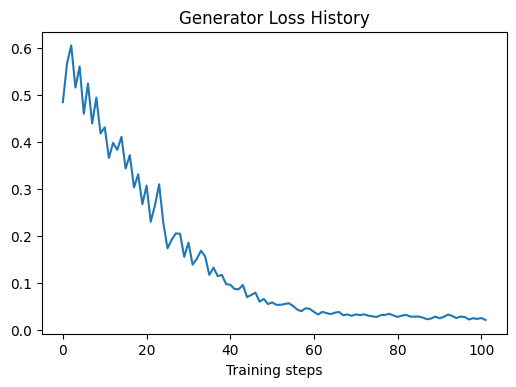

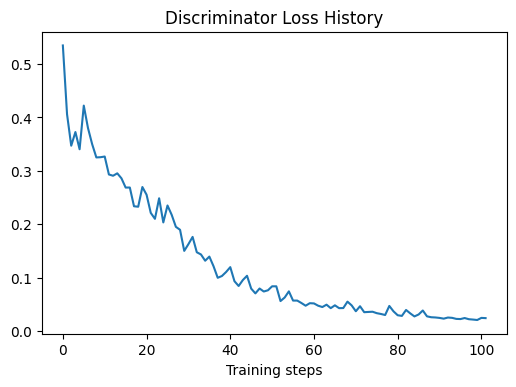

In [65]:
x = range(len(gen_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_loss_history)
plt.title('Generator Loss History')
plt.xlabel('Training steps')

x = range(len(disc_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_loss_history)
plt.title('Discriminator Loss History')
plt.xlabel('Training steps')

## Compare generated sequences between Random G and trained G

In [71]:
G0 = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)
seqs_random = generate_sequences(1000, G0,BATCH_SIZE, T)

In [72]:
seqs_trained = generate_sequences(1000, G, BATCH_SIZE, T)

In [73]:
seqs_random

<tf.Tensor: shape=(1000, 21, 1), dtype=float64, numpy=
array([[[1.],
        [0.],
        [2.],
        ...,
        [3.],
        [2.],
        [3.]],

       [[1.],
        [2.],
        [3.],
        ...,
        [5.],
        [4.],
        [4.]],

       [[1.],
        [2.],
        [3.],
        ...,
        [3.],
        [4.],
        [4.]],

       ...,

       [[1.],
        [2.],
        [1.],
        ...,
        [2.],
        [3.],
        [4.]],

       [[1.],
        [4.],
        [2.],
        ...,
        [3.],
        [3.],
        [3.]],

       [[1.],
        [2.],
        [3.],
        ...,
        [2.],
        [2.],
        [2.]]])>

In [74]:
seqs_trained

<tf.Tensor: shape=(1000, 21, 1), dtype=float64, numpy=
array([[[1.],
        [4.],
        [2.],
        ...,
        [1.],
        [5.],
        [2.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [3.],
        [3.],
        [2.]],

       [[1.],
        [3.],
        [2.],
        ...,
        [0.],
        [4.],
        [4.]],

       ...,

       [[1.],
        [2.],
        [4.],
        ...,
        [0.],
        [5.],
        [0.]],

       [[1.],
        [5.],
        [4.],
        ...,
        [0.],
        [1.],
        [1.]],

       [[1.],
        [4.],
        [3.],
        ...,
        [5.],
        [3.],
        [4.]]])>

## Save trained G and D weights

In [76]:
if not os.path.exists(model_save_dir + '/G_run_2021-03-26'):
    os.makedirs(model_save_dir + '/G_run_2021-03-26')

G_save_path = model_save_dir + '/G_run_2021-03-26/model.tf'
                
if not os.path.exists(model_save_dir + '/D_run_2021-03-26'):
    os.makedirs(model_save_dir + '/D_run_2021-03-26')

D_save_path = model_save_dir + '/D_run_2021-03-26/model.tf'

G.save_weights(G_save_path)
D.save_weights(D_save_path)

## Debug